In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

import warnings
warnings.filterwarnings('ignore')

register_matplotlib_converters()
%matplotlib inline

In [2]:
import psycopg2

postgresDb = psycopg2.connect(
    host="localhost",
    database="postgres",
    user="postgres",
    password="admin")

In [3]:
class Stockdatadao:
    def __init__(self, db):
        self.db = db

    def select(self, symbol):
        cursor = self.db.cursor()
        sql = """SELECT date_time, open, high, low, close, volume, adj_close
                    FROM stock_data WHERE symbol = %s"""
        val = (symbol,)

        cursor.execute(sql, val)
        result = cursor.fetchall()
        list_stock_data = []

        for item in result:
            list_stock_data.append(
                StockDataViewModel(date_time=item[0], open=item[1], high=item[2], low=item[3],
                                   close=item[4], volume=item[5], adj_close=item[6]))

        cursor.close()
        if result is None:
            return None
        else:
            return list_stock_data


class StockDataViewModel:
    def __init__(self, date_time, open, high, low, close, volume, adj_close):
        self.date_time = date_time
        self.open = open
        self.high = high
        self.low = low
        self.close = close
        self.volume = volume
        self.adj_close = adj_close

    def to_dict(self):
        return {
            'date_time': self.date_time,
            'open': self.open,
            'high': self.high,
            'low': self.low,
            'close': self.close,
            'volume': self.volume,
            'adj_close': self.adj_close
        }

In [4]:
stock_data_dao = Stockdatadao(postgresDb)
stock_data = stock_data_dao.select('AMD')

temp_df = pd.DataFrame.from_records([s.to_dict() for s in stock_data])

temp_df['date_time'] = pd.to_datetime(temp_df['date_time'], utc=True, format="ISO8601")
temp_df["date_time"] = temp_df["date_time"].dt.strftime("%Y-%m-%d")
temp_df.index = pd.DatetimeIndex(temp_df["date_time"]) #assign the changed column to the index
temp_df.sort_index(inplace=True)
temp_df = temp_df.loc['1980-08-06':'2023-07-07']
print(len(temp_df))
temp_df.tail(3)

10820


,date_time,open,high,low,close,volume,adj_close
date_time,,,,,,,
2023-07-05,2023-07-05,116.099998,117.660004,113.860001,113.949997,49501600.0,113.949997
2023-07-06,2023-07-06,112.070000,113.790001,110.309998,113.480003,42342000.0,113.480003
2023-07-07,2023-07-07,114.160004,115.330002,113.040001,113.169998,37135100.0,113.169998


In [5]:
#get the dataset from the csv file into df
df = pd.read_csv('/mnt/learning/last_project/fetch_data_stock/input/clean_amd.csv')
print(len(df))
df.tail(3)

10801


,Date,Open,High,Low,Close,Volume,NATR_3,RSI_3,ADX_3,CCI_3_0.015,...,BBM_3_2.0,BBU_3_2.0,BBB_3_2.0,BBP_3_2.0,min_price_3,max_price_3,mid_price,tema_2,tema_100,tema_8
10798,2023-07-05 00:00:00-04:00,116.099998,117.660004,113.860001,113.949997,49501600,3.058771,55.902291,60.012046,27.307241,...,114.560000,116.342208,3.111396,0.328863,112.410004,117.660004,115.760002,114.120879,121.479762,113.750856
10799,2023-07-06 00:00:00-04:00,112.070000,113.790001,110.309998,113.480003,42342000,3.139526,49.760901,47.188927,-100.000000,...,114.416667,116.438040,3.533355,0.268310,110.309998,117.660004,112.049999,113.442697,121.563613,113.809707
10800,2023-07-07 00:00:00-04:00,114.160004,115.330002,113.040001,113.169998,37135100,2.585816,44.882450,35.068771,0.253154,...,113.533333,114.174649,1.129741,0.216727,110.309998,117.660004,114.185001,113.123297,121.618117,113.665760


In [6]:
#rename the column in df

df = df.rename(columns={'Volume': 'volume',
                        'Open': 'open', 'High': 'high',
                        'Low': 'low', 'Close': 'close', 'Date':'date'})

df.head(2)

,date,open,high,low,close,volume,NATR_3,RSI_3,ADX_3,CCI_3_0.015,...,BBM_3_2.0,BBU_3_2.0,BBB_3_2.0,BBP_3_2.0,min_price_3,max_price_3,mid_price,tema_2,tema_100,tema_8
0,1980-08-06 00:00:00-04:00,0.0,4.333333,4.218750,4.239583,351600,3.193439,57.558179,67.457227,-70.588288,...,4.305555,4.408089,4.762848,0.178289,4.218750,4.416667,4.276042,4.244861,3.017500,4.373309
1,1980-08-07 00:00:00-04:00,0.0,4.270833,4.208333,4.218750,218400,2.345345,52.183414,53.444589,-70.149217,...,4.274305,4.403105,6.026714,0.284335,4.208333,4.416667,4.239583,4.213865,3.087458,4.334732


In [7]:
#Change the type of the date column from object to datetime in df

df['date'] = pd.to_datetime(df['date'], utc=True)
df["date"] = df["date"].dt.strftime("%Y-%m-%d")
df.index = pd.DatetimeIndex(df["date"]) #assign the changed column to the index
df.sort_index(inplace=True)
df.last('3D')

,date,open,high,low,close,volume,NATR_3,RSI_3,ADX_3,CCI_3_0.015,...,BBM_3_2.0,BBU_3_2.0,BBB_3_2.0,BBP_3_2.0,min_price_3,max_price_3,mid_price,tema_2,tema_100,tema_8
date,,,,,,,,,,,,,,,,,,,,,
2023-07-05,2023-07-05,116.099998,117.660004,113.860001,113.949997,49501600,3.058771,55.902291,60.012046,27.307241,...,114.560000,116.342208,3.111396,0.328863,112.410004,117.660004,115.760002,114.120879,121.479762,113.750856
2023-07-06,2023-07-06,112.070000,113.790001,110.309998,113.480003,42342000,3.139526,49.760901,47.188927,-100.000000,...,114.416667,116.438040,3.533355,0.268310,110.309998,117.660004,112.049999,113.442697,121.563613,113.809707
2023-07-07,2023-07-07,114.160004,115.330002,113.040001,113.169998,37135100,2.585816,44.882450,35.068771,0.253154,...,113.533333,114.174649,1.129741,0.216727,110.309998,117.660004,114.185001,113.123297,121.618117,113.665760


In [8]:
#drop column date if it exists in df

if 'date' in df.columns:
    df.drop(['date'], axis=1, inplace=True)

#check for null values in df
df.isnull().sum()

open             0
high             0
low              0
close            0
volume           0
NATR_3           0
RSI_3            0
ADX_3            0
CCI_3_0.015      0
ROC_3            0
STOCHk_14_3_3    0
STOCHd_14_3_3    0
WILLR_3          0
OBV              0
MACD_12_26_9     0
BBL_3_2.0        0
BBM_3_2.0        0
BBU_3_2.0        0
BBB_3_2.0        0
BBP_3_2.0        0
min_price_3      0
max_price_3      0
mid_price        0
tema_2           0
tema_100         0
tema_8           0
dtype: int64

In [9]:
# Get the unique indexes from both dataframes
indexes1 = set(temp_df.index)
indexes2 = set(df.index)

# Find the indexes that exist in df1 but not in df2
indexes_only_in_df1 = indexes1 - indexes2

# Find the indexes that exist in df2 but not in df1
indexes_only_in_df2 = indexes2 - indexes1

# Print the unique indexes present in each dataframe
print("Indexes only in df1:", indexes_only_in_df1)
print("Indexes only in df2:", indexes_only_in_df2)

Indexes only in df1: {Timestamp('2014-02-14 00:00:00'), Timestamp('1993-05-24 00:00:00'), Timestamp('1990-11-06 00:00:00'), Timestamp('1989-09-08 00:00:00'), Timestamp('1989-07-18 00:00:00'), Timestamp('1990-01-18 00:00:00'), Timestamp('1988-09-26 00:00:00'), Timestamp('1989-08-03 00:00:00'), Timestamp('1992-06-16 00:00:00'), Timestamp('1990-10-23 00:00:00'), Timestamp('1988-08-30 00:00:00'), Timestamp('1989-05-19 00:00:00'), Timestamp('1999-05-03 00:00:00'), Timestamp('1996-01-18 00:00:00'), Timestamp('1988-05-04 00:00:00'), Timestamp('1989-07-26 00:00:00'), Timestamp('1993-12-20 00:00:00'), Timestamp('1991-02-19 00:00:00'), Timestamp('1990-11-07 00:00:00')}
Indexes only in df2: set()


In [10]:
##{Timestamp('1992-06-16 00:00:00'), Timestamp('1999-05-03 00:00:00'), Timestamp('1993-05-24 00:00:00'), Timestamp('1990-10-23 00:00:00'), Timestamp('1989-08-03 00:00:00'), Timestamp('1996-01-18 00:00:00'), Timestamp('1990-01-18 00:00:00'), Timestamp('1989-07-18 00:00:00'), Timestamp('2014-02-14 00:00:00'), Timestamp('1993-12-20 00:00:00'), Timestamp('1989-05-19 00:00:00'), Timestamp('1988-08-30 00:00:00'), Timestamp('1989-09-08 00:00:00'), Timestamp('1988-05-04 00:00:00'), Timestamp('1991-02-19 00:00:00'), Timestamp('1989-07-26 00:00:00'), Timestamp('1988-09-26 00:00:00'), Timestamp('1990-11-06 00:00:00'), Timestamp('1990-11-07 00:00:00')}

temp_df = temp_df.drop(['1992-06-16', '1999-05-03', '1993-05-24', '1990-10-23', '1989-08-03', '1996-01-18', '1990-01-18', '1989-07-18', '2014-02-14', '1993-12-20', '1989-05-19', '1988-08-30', '1989-09-08', '1988-05-04', '1991-02-19', '1989-07-26', '1988-09-26', '1990-11-06', '1990-11-07'])

print(len(temp_df))
temp_df.head(3)

10801


,date_time,open,high,low,close,volume,adj_close
date_time,,,,,,,
1980-08-06,1980-08-06,0.0,4.333333,4.218750,4.239583,351600.0,4.239583
1980-08-07,1980-08-07,0.0,4.270833,4.208333,4.218750,218400.0,4.218750
1980-08-08,1980-08-08,0.0,4.333333,4.260417,4.270833,471600.0,4.270833


In [11]:
#add adj_close into main df

df['adj_close'] = temp_df['adj_close']
df.head(2)

,open,high,low,close,volume,NATR_3,RSI_3,ADX_3,CCI_3_0.015,ROC_3,...,BBU_3_2.0,BBB_3_2.0,BBP_3_2.0,min_price_3,max_price_3,mid_price,tema_2,tema_100,tema_8,adj_close
date,,,,,,,,,,,,,,,,,,,,,
1980-08-06,0.0,4.333333,4.218750,4.239583,351600,3.193439,57.558179,67.457227,-70.588288,-0.489012,...,4.408089,4.762848,0.178289,4.218750,4.416667,4.276042,4.244861,3.017500,4.373309,4.239583
1980-08-07,0.0,4.270833,4.208333,4.218750,218400,2.345345,52.183414,53.444589,-70.149217,-2.173913,...,4.403105,6.026714,0.284335,4.208333,4.416667,4.239583,4.213865,3.087458,4.334732,4.218750


In [12]:
df.isnull().sum()

open             0
high             0
low              0
close            0
volume           0
NATR_3           0
RSI_3            0
ADX_3            0
CCI_3_0.015      0
ROC_3            0
STOCHk_14_3_3    0
STOCHd_14_3_3    0
WILLR_3          0
OBV              0
MACD_12_26_9     0
BBL_3_2.0        0
BBM_3_2.0        0
BBU_3_2.0        0
BBB_3_2.0        0
BBP_3_2.0        0
min_price_3      0
max_price_3      0
mid_price        0
tema_2           0
tema_100         0
tema_8           0
adj_close        0
dtype: int64

In [13]:
null_values = df[df['adj_close'].isnull()]

# Print the resulting dataframe containing the null values
print(null_values)

Empty DataFrame
Columns: [open, high, low, close, volume, NATR_3, RSI_3, ADX_3, CCI_3_0.015, ROC_3, STOCHk_14_3_3, STOCHd_14_3_3, WILLR_3, OBV, MACD_12_26_9, BBL_3_2.0, BBM_3_2.0, BBU_3_2.0, BBB_3_2.0, BBP_3_2.0, min_price_3, max_price_3, mid_price, tema_2, tema_100, tema_8, adj_close]
Index: []

[0 rows x 27 columns]


In [14]:
df['volume'] = df['volume'].astype(float)

In [15]:
###get the dataset of apple stock from 2013-01-01 to 2023-06-01 from df
df = df.loc['2013-01-01':'2023-06-29']
df.index

DatetimeIndex(['2013-01-02', '2013-01-03', '2013-01-04', '2013-01-07',
               '2013-01-08', '2013-01-09', '2013-01-10', '2013-01-11',
               '2013-01-14', '2013-01-15',
               ...
               '2023-06-15', '2023-06-16', '2023-06-20', '2023-06-21',
               '2023-06-22', '2023-06-23', '2023-06-26', '2023-06-27',
               '2023-06-28', '2023-06-29'],
              dtype='datetime64[ns]', name='date', length=2640, freq=None)

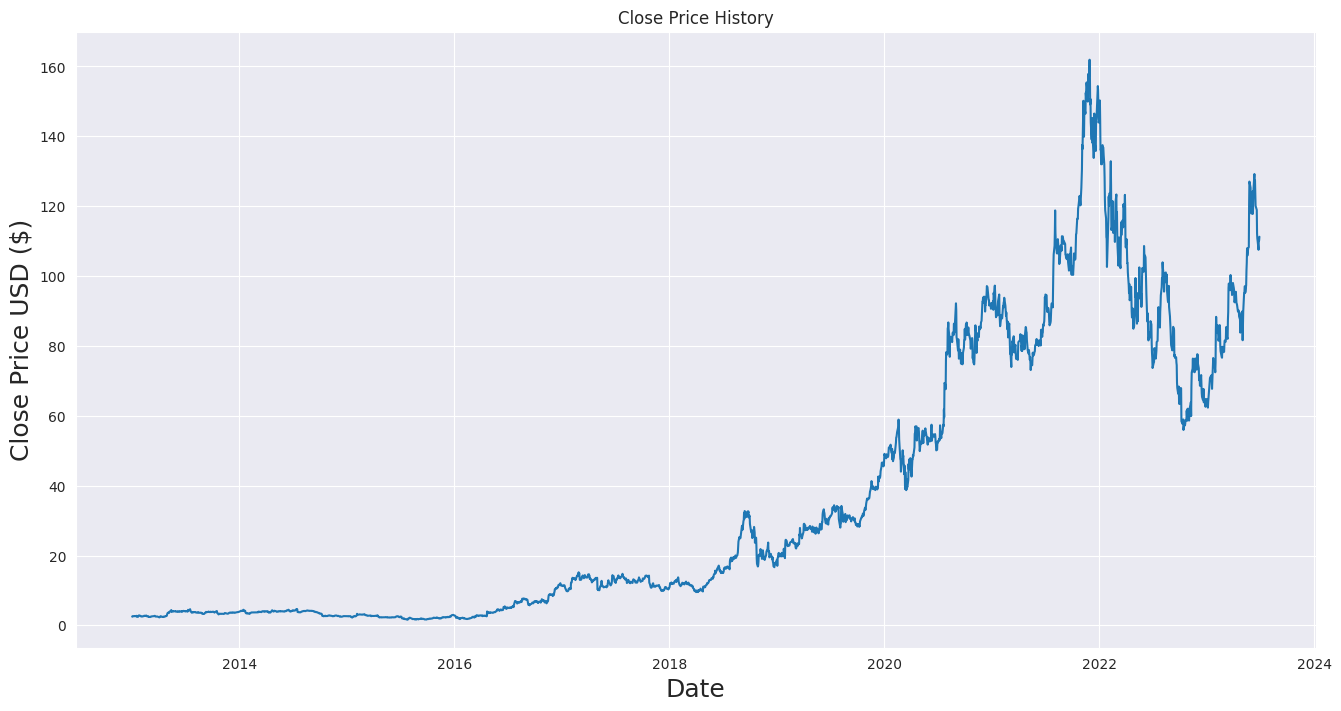

In [16]:
###plot the close price history of AAPL stock from 2013-01-01 to 2023-06-01 from df using matplotlib

plt.figure(figsize=(16, 8))
plt.title('Close Price History')
plt.plot(df['close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2640 entries, 2013-01-02 to 2023-06-29
Data columns (total 27 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   open           2640 non-null   float64
 1   high           2640 non-null   float64
 2   low            2640 non-null   float64
 3   close          2640 non-null   float64
 4   volume         2640 non-null   float64
 5   NATR_3         2640 non-null   float64
 6   RSI_3          2640 non-null   float64
 7   ADX_3          2640 non-null   float64
 8   CCI_3_0.015    2640 non-null   float64
 9   ROC_3          2640 non-null   float64
 10  STOCHk_14_3_3  2640 non-null   float64
 11  STOCHd_14_3_3  2640 non-null   float64
 12  WILLR_3        2640 non-null   float64
 13  OBV            2640 non-null   float64
 14  MACD_12_26_9   2640 non-null   float64
 15  BBL_3_2.0      2640 non-null   float64
 16  BBM_3_2.0      2640 non-null   float64
 17  BBU_3_2.0      2640 non-null   flo

In [18]:
#We need to restructure the data set by adding a target column ‘Actual’, which will the stock prices for the next day.

steps=-1
main_dataset = df.copy()
main_dataset['Next date'] = main_dataset['close'].shift(steps)
main_dataset.last('3D')

,open,high,low,close,volume,NATR_3,RSI_3,ADX_3,CCI_3_0.015,ROC_3,...,BBB_3_2.0,BBP_3_2.0,min_price_3,max_price_3,mid_price,tema_2,tema_100,tema_8,adj_close,Next date
date,,,,,,,,,,,,,,,,,,,,,
2023-06-27,108.570000,110.970001,107.080002,110.389999,59381600.0,3.972214,40.737500,63.326914,42.168833,-0.280034,...,4.675179,0.712649,107.080002,112.550003,109.025002,110.225836,120.992671,107.280449,110.389999,110.169998
2023-06-28,108.209999,111.779999,107.629997,110.169998,67534100.0,3.873527,39.075495,49.439979,98.856896,0.145438,...,4.787542,0.655349,107.080002,112.550003,109.704998,110.289728,120.943689,107.614755,110.169998,111.239998
2023-06-29,112.070000,112.760002,109.839996,111.239998,58347200.0,3.230614,53.049678,36.721870,100.000000,3.469441,...,1.668624,0.846790,107.080002,112.760002,111.299999,111.254857,120.950636,108.605059,111.239998,NaN


In [19]:
main_dataset.isnull().sum()

open             0
high             0
low              0
close            0
volume           0
NATR_3           0
RSI_3            0
ADX_3            0
CCI_3_0.015      0
ROC_3            0
STOCHk_14_3_3    0
STOCHd_14_3_3    0
WILLR_3          0
OBV              0
MACD_12_26_9     0
BBL_3_2.0        0
BBM_3_2.0        0
BBU_3_2.0        0
BBB_3_2.0        0
BBP_3_2.0        0
min_price_3      0
max_price_3      0
mid_price        0
tema_2           0
tema_100         0
tema_8           0
adj_close        0
Next date        1
dtype: int64

In [20]:
##dropping columns with null values in dataset_for_prediction

main_dataset.dropna(inplace=True)
main_dataset.last('3D')

,open,high,low,close,volume,NATR_3,RSI_3,ADX_3,CCI_3_0.015,ROC_3,...,BBB_3_2.0,BBP_3_2.0,min_price_3,max_price_3,mid_price,tema_2,tema_100,tema_8,adj_close,Next date
date,,,,,,,,,,,,,,,,,,,,,
2023-06-26,110.949997,112.550003,107.199997,107.510002,68557000.0,4.538978,5.753575,68.502763,-64.807822,-4.103112,...,5.010327,0.153996,107.199997,114.000000,109.875000,107.590994,121.021568,106.977734,107.510002,110.389999
2023-06-27,108.570000,110.970001,107.080002,110.389999,59381600.0,3.972214,40.737500,63.326914,42.168833,-0.280034,...,4.675179,0.712649,107.080002,112.550003,109.025002,110.225836,120.992671,107.280449,110.389999,110.169998
2023-06-28,108.209999,111.779999,107.629997,110.169998,67534100.0,3.873527,39.075495,49.439979,98.856896,0.145438,...,4.787542,0.655349,107.080002,112.550003,109.704998,110.289728,120.943689,107.614755,110.169998,111.239998


Text(0.5, 1.0, ' Apple Stock Value')

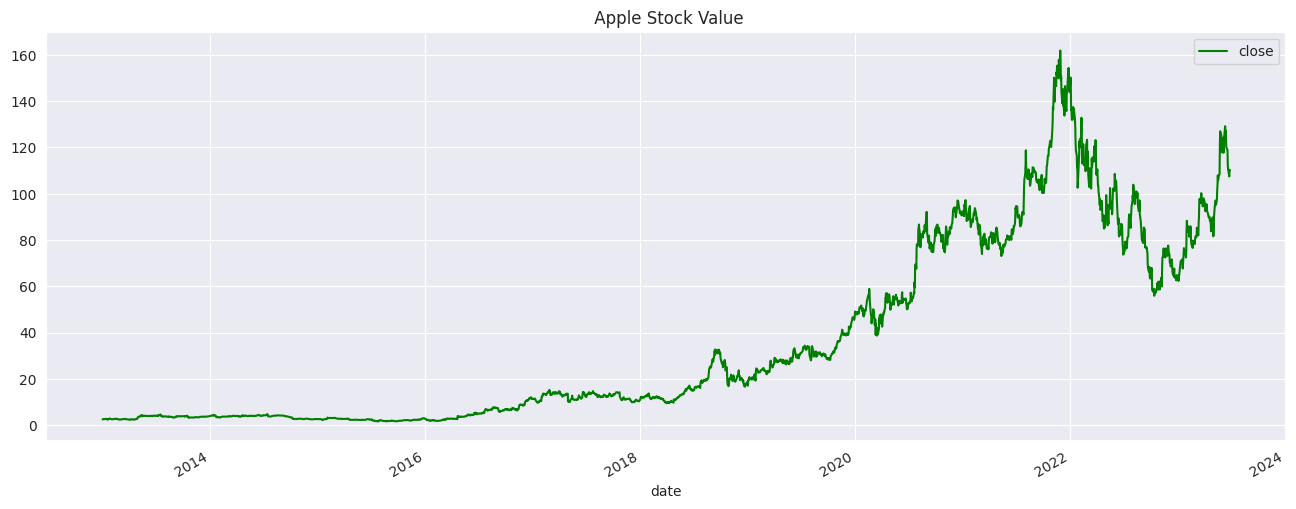

In [21]:
#plot the mean stock prices for the current dataset and lock the trends from df

main_dataset['close'].plot(color='green', figsize=(16, 6))
plt.legend(['close'])
plt.title(" Apple Stock Value")

Text(0.5, 1.0, ' Apple Stock Volume')

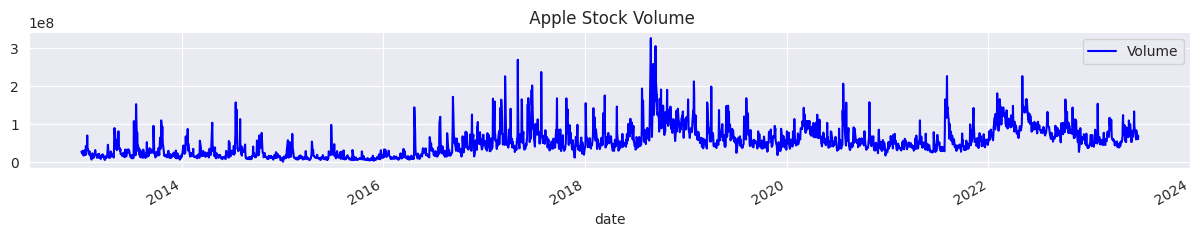

In [22]:
#Plotting volume of Apple stocks sold daily from df

main_dataset['volume'].plot(color='blue', figsize=(15, 2))
plt.legend(['Volume'])
plt.title(" Apple Stock Volume")

In [23]:
test_close = main_dataset[['close']]
test_close.head(4)

,close
date,
2013-01-02,2.53
2013-01-03,2.49
2013-01-04,2.59
2013-01-07,2.67


In [24]:
test_actual = main_dataset[['close',
                            'Next date']]
test_actual.tail(10)

,close,Next date
date,,
2023-06-14,127.330002,124.239998
2023-06-15,124.239998,120.080002
2023-06-16,120.080002,118.930000
2023-06-20,118.930000,112.110001
2023-06-21,112.110001,110.699997
2023-06-22,110.699997,110.010002
2023-06-23,110.010002,107.510002
2023-06-26,107.510002,110.389999
2023-06-27,110.389999,110.169998


In [25]:
#Normalizing the input and target features
#Since the stock prices and volume are on a different scale, we need to normalize the data. We use StandardScaler to normalize the data. The scaler is fit on the training set and then applied to the test set. This means we need to fit the scaler on the training set and apply the same scaler to the test set.

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_data = scaler.fit_transform(main_dataset[['low', 'high', 'open', 'close', 'volume',
                                                 'NATR_3', 'RSI_3', 'ADX_3', 'CCI_3_0.015',
                                                 'ROC_3','STOCHk_14_3_3', 'STOCHd_14_3_3',
                                                 'WILLR_3','OBV', 'MACD_12_26_9', 'BBL_3_2.0',
                                                 'BBM_3_2.0','BBU_3_2.0', 'BBB_3_2.0',
                                                 'BBP_3_2.0', 'min_price_3', 'max_price_3',
                                                 'mid_price', 'tema_2', 'tema_100','tema_8',"adj_close"]])
# scaled_data = scaler.fit_transform(main_dataset[["close", 'Next date']])
scaled_data = pd.DataFrame(scaled_data)

X = scaled_data
X.tail(3)

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
2636,1.867224,1.883512,1.901079,1.814712,0.438036,-0.022668,-1.831420,0.986628,-0.864716,-0.751561,...,1.830502,-0.381866,-1.351795,1.925980,1.866915,1.875698,1.816768,2.159832,1.800407,1.814712
2637,1.864114,1.844285,1.840763,1.887732,0.195558,-0.306482,-0.476659,0.689942,0.456146,-0.144876,...,1.823438,-0.436534,0.747219,1.922805,1.831593,1.854139,1.883573,2.159100,1.808079,1.887732
2638,1.878369,1.864395,1.831639,1.882154,0.411004,-0.355901,-0.541021,-0.106075,1.156085,-0.077358,...,1.826273,-0.418206,0.531928,1.922805,1.831593,1.871386,1.885193,2.157859,1.816552,1.882154


In [26]:
#Scaling the target feature
scaler_target = StandardScaler()
scaled_target = scaler_target.fit_transform(main_dataset[['Next date']])
scaled_target = pd.DataFrame(scaled_target)

Y = scaled_target
Y.tail(3)

,0
2636,1.885643
2637,1.880068
2638,1.907182


In [27]:
#rename X

X.rename(columns={0:'open', 1:'high', 2:'low', 3:'close', 4:'volume', 5:'NATR_3', 6:'RSI_3', 7:'ADX_3', 8:'CCI_3_0.015',
                  9:'ROC_3', 10:'STOCHk_14_3_3', 11:'STOCHd_14_3_3', 12:'WILLR_3',13:'OBV', 14:'MACD_12_26_9',
                  15:'BBL_3_2.0', 16:'BBM_3_2.0', 17:'BBU_3_2.0', 18:'BBB_3_2.0', 19:'BBP_3_2.0', 20:'min_price_3',
                  21:'max_price_3', 22:'mid_price', 23:'tema_2', 24:'tema_100',25:'tema_8',26: 'adj_close'}, inplace=True)
X.index=main_dataset.index
X.tail(3)

,open,high,low,close,volume,NATR_3,RSI_3,ADX_3,CCI_3_0.015,ROC_3,...,BBU_3_2.0,BBB_3_2.0,BBP_3_2.0,min_price_3,max_price_3,mid_price,tema_2,tema_100,tema_8,adj_close
date,,,,,,,,,,,,,,,,,,,,,
2023-06-26,1.867224,1.883512,1.901079,1.814712,0.438036,-0.022668,-1.831420,0.986628,-0.864716,-0.751561,...,1.830502,-0.381866,-1.351795,1.925980,1.866915,1.875698,1.816768,2.159832,1.800407,1.814712
2023-06-27,1.864114,1.844285,1.840763,1.887732,0.195558,-0.306482,-0.476659,0.689942,0.456146,-0.144876,...,1.823438,-0.436534,0.747219,1.922805,1.831593,1.854139,1.883573,2.159100,1.808079,1.887732
2023-06-28,1.878369,1.864395,1.831639,1.882154,0.411004,-0.355901,-0.541021,-0.106075,1.156085,-0.077358,...,1.826273,-0.418206,0.531928,1.922805,1.831593,1.871386,1.885193,2.157859,1.816552,1.882154


In [28]:
#rename Y

Y.rename(columns={0:'Next date'}, inplace=True)
Y.index=main_dataset.index
Y.head(3)

,Next date
date,
2013-01-02,-0.848579
2013-01-03,-0.846045
2013-01-04,-0.844017


In [29]:
#Get the dataset for validation from df
df_for_validation = X.loc['2023-01-01':'2023-06-28']
df_for_validation.tail(3)

,open,high,low,close,volume,NATR_3,RSI_3,ADX_3,CCI_3_0.015,ROC_3,...,BBU_3_2.0,BBB_3_2.0,BBP_3_2.0,min_price_3,max_price_3,mid_price,tema_2,tema_100,tema_8,adj_close
date,,,,,,,,,,,,,,,,,,,,,
2023-06-26,1.867224,1.883512,1.901079,1.814712,0.438036,-0.022668,-1.831420,0.986628,-0.864716,-0.751561,...,1.830502,-0.381866,-1.351795,1.925980,1.866915,1.875698,1.816768,2.159832,1.800407,1.814712
2023-06-27,1.864114,1.844285,1.840763,1.887732,0.195558,-0.306482,-0.476659,0.689942,0.456146,-0.144876,...,1.823438,-0.436534,0.747219,1.922805,1.831593,1.854139,1.883573,2.159100,1.808079,1.887732
2023-06-28,1.878369,1.864395,1.831639,1.882154,0.411004,-0.355901,-0.541021,-0.106075,1.156085,-0.077358,...,1.826273,-0.418206,0.531928,1.922805,1.831593,1.871386,1.885193,2.157859,1.816552,1.882154


In [30]:
df_for_validation_actual = Y.loc['2023-01-01':'2023-06-28']
df_for_validation_actual.head(2)

,Next date
date,
2023-01-03,0.726830
2023-01-04,0.667787


In [31]:
#Get the train from X between 2013-01-01 and 2022-12-31

X = X.loc['2013-01-01':'2022-12-31']
X.last('3D')

,open,high,low,close,volume,NATR_3,RSI_3,ADX_3,CCI_3_0.015,ROC_3,...,BBU_3_2.0,BBB_3_2.0,BBP_3_2.0,min_price_3,max_price_3,mid_price,tema_2,tema_100,tema_8,adj_close
date,,,,,,,,,,,,,,,,,,,,,
2022-12-28,0.694613,0.666750,0.674223,0.675286,-0.329154,-0.756913,-1.145380,-0.168159,-1.299241,-0.420999,...,0.680045,-0.369769,-1.080480,0.728778,0.664984,0.680437,0.674904,0.710467,0.676188,0.675286
2022-12-29,0.723125,0.707466,0.702100,0.732334,-0.278890,-0.544802,0.226963,-0.825622,1.170199,-0.026651,...,0.689017,-0.233930,1.213779,0.728778,0.677651,0.715185,0.729364,0.707716,0.697258,0.732334
2022-12-30,0.725198,0.698528,0.705394,0.731066,-0.392566,-0.770096,0.192286,-1.263931,0.489502,0.275782,...,0.706558,-0.130515,0.589924,0.728778,0.677651,0.711634,0.733179,0.705090,0.711071,0.731066


In [32]:
Y = Y.loc['2013-01-01':'2022-12-31']
Y.last('3D')

,Next date
date,
2022-12-28,0.730884
2022-12-29,0.729617
2022-12-30,0.710612


In [33]:
#Splitting the dataset into training and testing sets

temp_df = main_dataset.loc['2013-01-01':'2022-12-31']

train_size = int(len(temp_df) * 0.80)
test_size = int(len(temp_df) - train_size)
print(test_size)

504


In [34]:
#Splitting the dataset into training and testing sets using train_size and test_size from df and y respectively
train_X, train_Y = X[:train_size].dropna(), Y[:train_size].dropna()
test_X, test_Y = X[train_size:].dropna(), Y[train_size:].dropna()

In [35]:
test_X.columns

Index(['open', 'high', 'low', 'close', 'volume', 'NATR_3', 'RSI_3', 'ADX_3',
       'CCI_3_0.015', 'ROC_3', 'STOCHk_14_3_3', 'STOCHd_14_3_3', 'WILLR_3',
       'OBV', 'MACD_12_26_9', 'BBL_3_2.0', 'BBM_3_2.0', 'BBU_3_2.0',
       'BBB_3_2.0', 'BBP_3_2.0', 'min_price_3', 'max_price_3', 'mid_price',
       'tema_2', 'tema_100', 'tema_8', 'adj_close'],
      dtype='object')

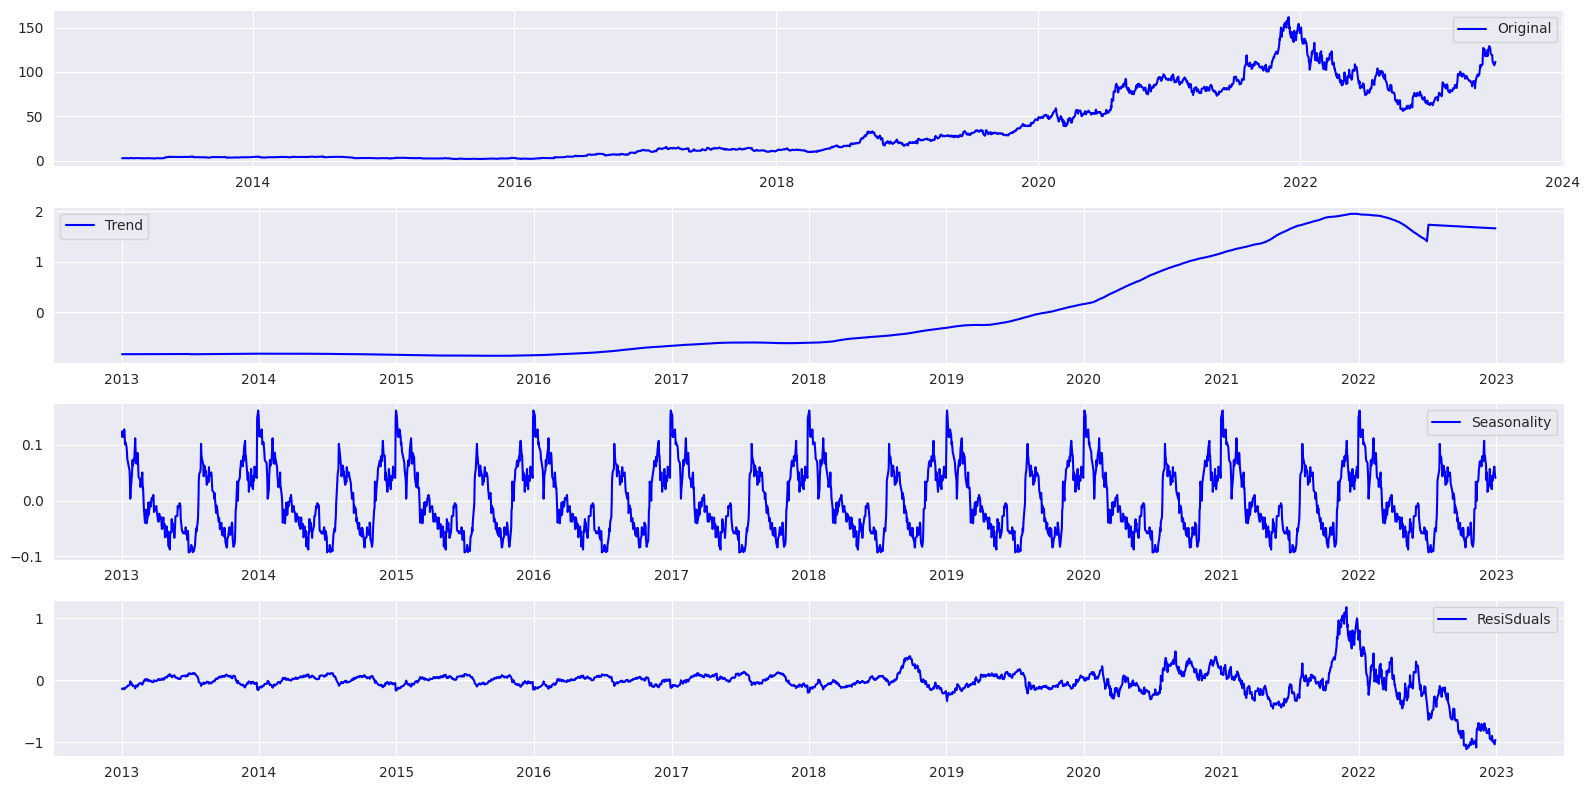

In [36]:
from statsmodels.tsa.stattools import acf
# ###Understanding the Time series data
# Decomposing Time Series into several components-Trend, Seasonality, and Random noise
#
# We know that Time series data is composed of Level, Trend, Seasonality, and Random noise. Let’s decompose the data and plot the trend, seasonality, and randomness in the data.
#
# We use statsmodel for seasonal decompose as an additive model and the frequency of the time series, which is the periodicity of the data, which is 365 days for yearly data.
#
# Additive model = Trend + Seasonality + Random Noise

from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(X['close'], model='add', period=252, extrapolate_trend='freq', two_sided=True, filt=None)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid


plt.figure(figsize=(16, 8))
plt.subplot(411)
plt.plot(df['close'], label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality', color='blue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='ResiSduals', color='blue')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [37]:
###Check for Data Stationarity using Augmented Dickey-Fuller(ADF) test.

from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

def test_adf(series, title=''):
    dfout={}
    dftest = sm.tsa.adfuller(series.dropna(), autolag='AIC', regression='ct')
    for key,val in dftest[4].items():
        dfout[f'critical value ({key})']=val
    if dftest[1]<=0.05:
        print("Strong evidence against Null Hypothesis")
        print("Reject Null Hypothesis - Data is  Stationary")
        print("Data is Stationary", title)
    else:
        print("Strong evidence for  Null Hypothesis")
        print("Accept Null Hypothesis - Data is not Stationary")
        print("Data is NOT Stationary for", title)


In [38]:
#Checking for stationary in the data using the ADF test

y_test = Y['Next date'][:train_size].dropna()
test_adf(y_test, 'Next date')

Strong evidence for  Null Hypothesis
Accept Null Hypothesis - Data is not Stationary
Data is NOT Stationary for Next date


In [39]:
#Make the data stationary by differencing the data
y_test_diff = y_test.diff().dropna()
test_adf(y_test_diff, 'Stock Price Next Day')

Strong evidence against Null Hypothesis
Reject Null Hypothesis - Data is  Stationary
Data is Stationary Stock Price Next Day


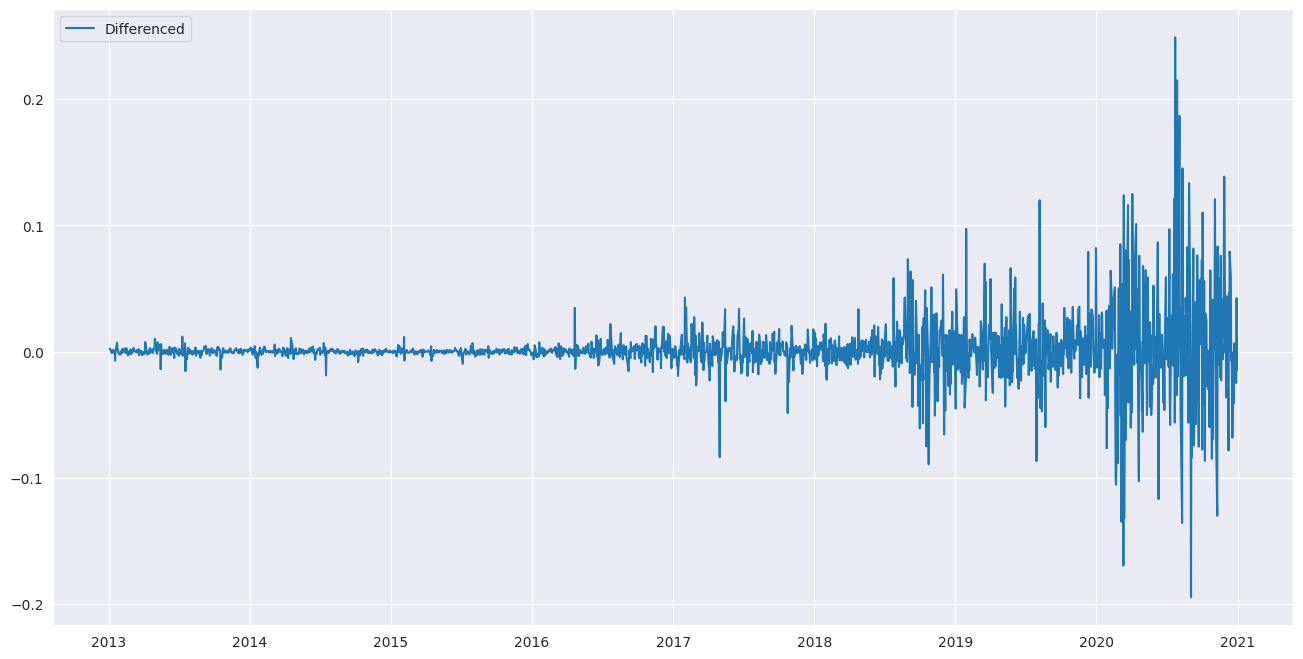

In [40]:
#Plotting the differenced data

plt.figure(figsize=(16, 8))
plt.plot(y_test_diff, label='Differenced')
plt.legend(loc='best')
plt.show()

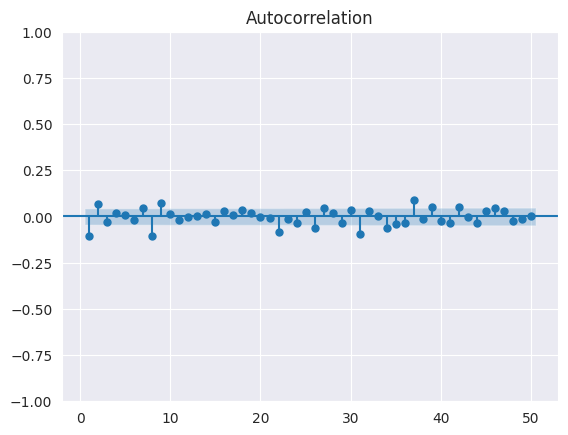

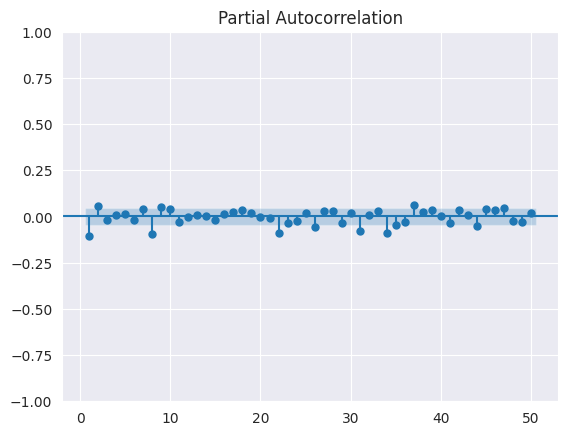

In [41]:
#Plotting the autocorrelation plot for the differenced data

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(y_test_diff, lags=50, zero=False)
plot_pacf(y_test_diff, lags=50, zero=False)
plt.show()

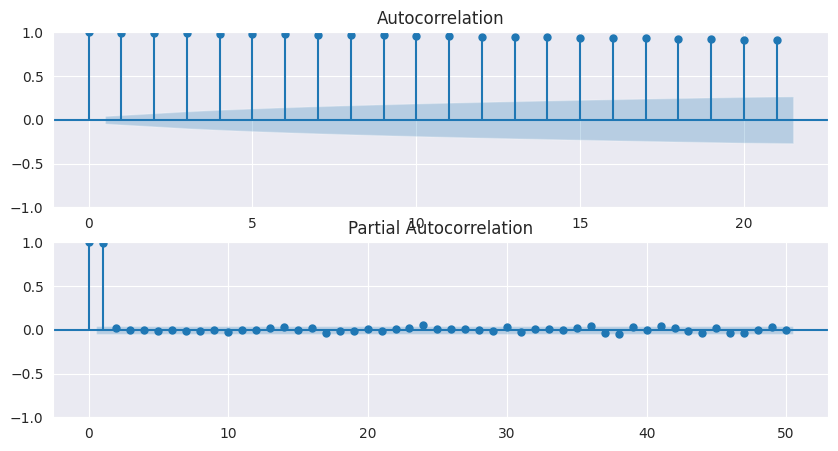

In [42]:
fig,ax= plt.subplots(2,1, figsize=(10,5))
fig=sm.tsa.graphics.plot_acf(y_test, lags=21, ax=ax[0])
fig=sm.tsa.graphics.plot_pacf(y_test, lags=50, ax=ax[1])
plt.show()

In [43]:
#Get only tema_2 from train_X, test_X

train_X_with_tema_2 = train_X.drop(['tema_8', 'tema_100'], axis=1)
text_X_with_tema_2 = test_X.drop(['tema_8' , 'tema_100'], axis=1)

train_X_with_tema_2.columns

Index(['open', 'high', 'low', 'close', 'volume', 'NATR_3', 'RSI_3', 'ADX_3',
       'CCI_3_0.015', 'ROC_3', 'STOCHk_14_3_3', 'STOCHd_14_3_3', 'WILLR_3',
       'OBV', 'MACD_12_26_9', 'BBL_3_2.0', 'BBM_3_2.0', 'BBU_3_2.0',
       'BBB_3_2.0', 'BBP_3_2.0', 'min_price_3', 'max_price_3', 'mid_price',
       'tema_2', 'adj_close'],
      dtype='object')

In [44]:
#Get only tema_8 from train_X, test_X

train_X_with_tema_8 = train_X.drop(['tema_2', 'tema_100'], axis=1)
text_X_with_tema_8 = test_X.drop(['tema_2', 'tema_100'], axis=1)

train_X_with_tema_8.columns

Index(['open', 'high', 'low', 'close', 'volume', 'NATR_3', 'RSI_3', 'ADX_3',
       'CCI_3_0.015', 'ROC_3', 'STOCHk_14_3_3', 'STOCHd_14_3_3', 'WILLR_3',
       'OBV', 'MACD_12_26_9', 'BBL_3_2.0', 'BBM_3_2.0', 'BBU_3_2.0',
       'BBB_3_2.0', 'BBP_3_2.0', 'min_price_3', 'max_price_3', 'mid_price',
       'tema_8', 'adj_close'],
      dtype='object')

In [45]:
#Get only tema_100 from train_X, test_X

train_X_with_tema_100 = train_X.drop(['tema_2', 'tema_8'], axis=1)
text_X_with_tema_100 = test_X.drop(['tema_2', 'tema_8'], axis=1)

train_X_with_tema_100.columns

Index(['open', 'high', 'low', 'close', 'volume', 'NATR_3', 'RSI_3', 'ADX_3',
       'CCI_3_0.015', 'ROC_3', 'STOCHk_14_3_3', 'STOCHd_14_3_3', 'WILLR_3',
       'OBV', 'MACD_12_26_9', 'BBL_3_2.0', 'BBM_3_2.0', 'BBU_3_2.0',
       'BBB_3_2.0', 'BBP_3_2.0', 'min_price_3', 'max_price_3', 'mid_price',
       'tema_100', 'adj_close'],
      dtype='object')

In [46]:
#Get df without tema from train_X, test_X

train_X_without_tema = train_X.drop(['tema_2', 'tema_8', 'tema_100'], axis=1)
text_X_without_tema = test_X.drop(['tema_2', 'tema_8', 'tema_100'], axis=1)

text_X_without_tema.columns

Index(['open', 'high', 'low', 'close', 'volume', 'NATR_3', 'RSI_3', 'ADX_3',
       'CCI_3_0.015', 'ROC_3', 'STOCHk_14_3_3', 'STOCHd_14_3_3', 'WILLR_3',
       'OBV', 'MACD_12_26_9', 'BBL_3_2.0', 'BBM_3_2.0', 'BBU_3_2.0',
       'BBB_3_2.0', 'BBP_3_2.0', 'min_price_3', 'max_price_3', 'mid_price',
       'adj_close'],
      dtype='object')

In [78]:
#Get the best parameters of seasonal orders for the SAIRMAX model using the auto_arima function from pmdarima library.

from pmdarima.arima import auto_arima

stepwise_model = auto_arima(train_Y, exogenous=train_X, start_p=1, start_q=1,
                            max_p=7, max_q=7, m=7,
                            start_P=0, seasonal=False,
                            d=1, max_d=7, trace=True,
                            error_action='ignore',
                            suppress_warnings=True,
                            stepwise=True)

stepwise_model.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-9318.765, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-9294.023, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-9315.021, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-9312.633, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-9291.619, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-9317.680, Time=0.20 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-9317.740, Time=0.52 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-9317.806, Time=0.26 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-9319.049, Time=0.22 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-9317.700, Time=0.20 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-9315.662, Time=0.20 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-9316.171, Time=0.04 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0] intercept
Total fit time: 2.215 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2013
Model:               SARIMAX(2, 1, 0)   Log Likelihood                4663.524
Date:                Mon, 17 Jul 2023   AIC                          -9319.049
Time:                        21:53:27   BIC                          -9296.621
Sample:                             0   HQIC                         -9310.816
                               - 2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0012      0.001      2.139      0.032    9.82e-05       0.002
ar.L1         -0.1008      0.010     -9.702      0.000      -0.121      -0.080
ar.L2          0.0548      0.010      5.642      0.000       0.036       0.074
sigma2         0.0006   5.39e-06    105.254      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             36556.57
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):             198.80   Skew:                             0.78
Prob(H) (two-sided):                  0.00   Kurtosis:                        23.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [47]:
#set the order and seasonal order for all project
from statsmodels.tsa.statespace.sarimax import SARIMAX
#Average Mean Absolute Percentage Error:  9.007967559508627 (tema_2), 9.494701458098493 (tema_8), 10.553632591175544 (tema_100)
# order = (1, 1, 1)
# seasonal_order = (2, 1, 0, 12)
#ARIMA(2,1,0)(2,1,0)[12]
import warnings
warnings.filterwarnings('ignore')
#Average Mean Absolute Percentage Error:  8.929140381017902(tema_2), 9.432941139268372 (tema_8), tema_100
order = (2, 1, 0)
seasonal_order = (2, 1, 0, 18)

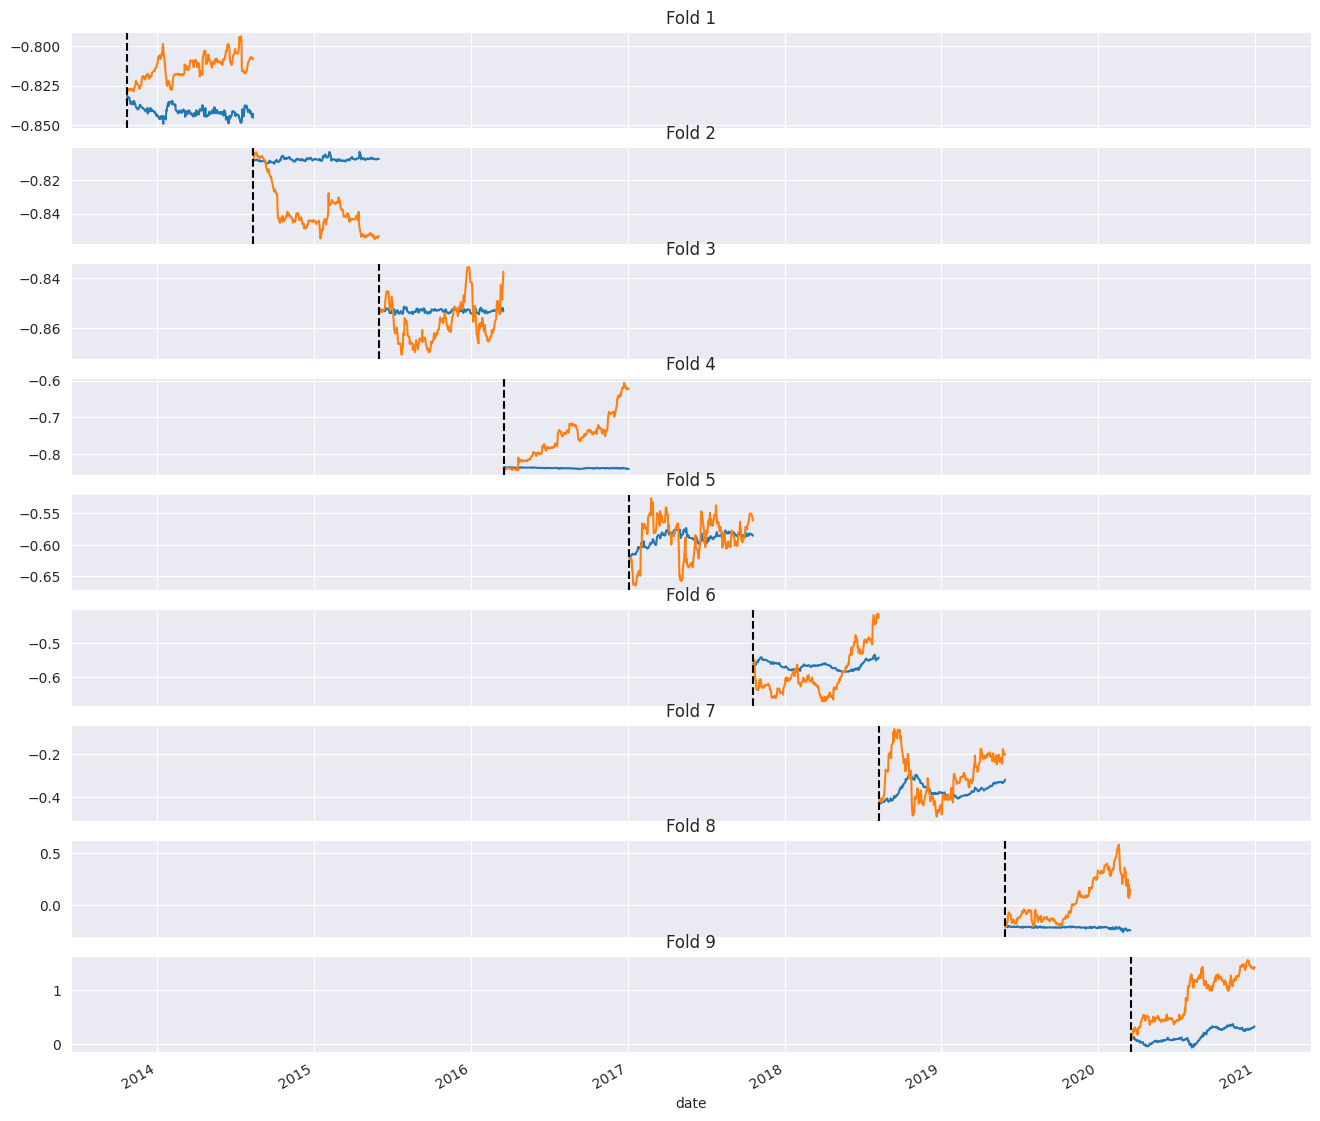

Average Mean Absolute Percentage Error:  0.9798097808497067


In [80]:
##using tema_2
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_percentage_error


import warnings
warnings.filterwarnings('ignore')

total_samples = len(train_X_with_tema_2)  # Mỗi mẫu tương ứng với một năm

test_size_ratio = 0.1  # Tỷ lệ phần trăm dùng cho tập kiểm tra
test_size = int(total_samples * test_size_ratio)
tscv = TimeSeriesSplit(n_splits=9, test_size=test_size, gap=0)

train_X_with_tema_2 = train_X_with_tema_2.sort_index()
train_Y = train_Y.sort_index()
# print(train_X.head())|
figure, ax = plt.subplots(9, 1 , figsize=(16, 15), sharex=True)
fold = 0
the_average_mape = 0


for train_index, test_index in tscv.split(train_X_with_tema_2):
    X_train, X_test = train_X_with_tema_2.iloc[train_index], train_X_with_tema_2.iloc[test_index]
    y_train, y_test = train_Y.iloc[train_index], train_Y.iloc[test_index]

    #turn off the output of the model
    model = SARIMAX(endog=y_train, exog=X_train, order=order)

    model_fit = model.fit(maxiter=200, method='powell', disp=False, full_output=False)
    y_pred = model_fit.forecast(steps=len(X_test), exog=X_test)

    y_pred.reset_index(drop=True, inplace=True)
    result = pd.DataFrame(y_pred)
    result.reset_index(drop=True, inplace=True)
    result.index=X_test.index
    result["Next date"] = y_test
    ##plot the predicted and actual values from y_pred and x_test
    result["predicted_mean"].plot(ax=ax[fold], label='Predicted Set', title='Fold {}'.format(fold+1))
    result["Next date"].plot(ax=ax[fold], label='Actual Set')
    ax[fold].axvline(X_test.index.min(), color='black', ls='--')
    fold+= 1

    mape = mean_absolute_percentage_error(y_test, y_pred)
    the_average_mape = the_average_mape + mape

plt.show()
print("Average Mean Absolute Percentage Error: ", the_average_mape/5)

In [48]:
from statsmodels.tsa.arima.model import ARIMA
#Predicting the values in the validation data using the ARIMA model

model = SARIMAX(endog=train_Y, exog=train_X_with_tema_2, order=order, seasonal_order=seasonal_order)
model_fit = model.fit(maxiter=200, method='powell', disp=False, full_output=False)
print(model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                          Next date   No. Observations:                 2013
Model:             SARIMAX(2, 1, 0)x(2, 1, 0, 18)   Log Likelihood                4363.954
Date:                            Sat, 22 Jul 2023   AIC                          -8667.909
Time:                                    01:06:56   BIC                          -8499.972
Sample:                                         0   HQIC                         -8606.236
                                           - 2013                                         
Covariance Type:                              opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
open              0.3239      0.034      9.618      0.000       0.258       0.390
high             -0.1875  

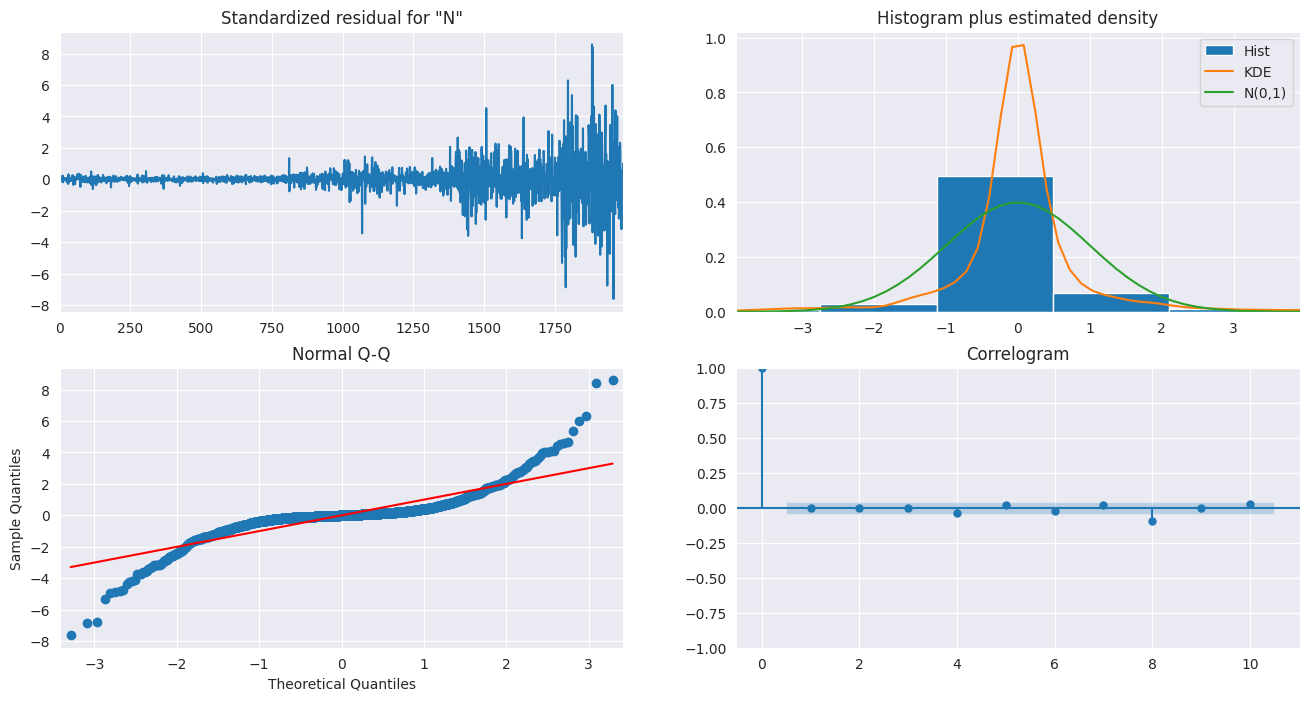

In [49]:
#plot the result of model fit

model_fit.plot_diagnostics(figsize=(16, 8))
plt.show()

In [50]:
from sklearn.metrics import mean_squared_error


def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [51]:
#Predicting the values in the validation data using the SARIMAX model
forecast = model_fit.forecast(steps=len(text_X_with_tema_2), exog=text_X_with_tema_2)

<Axes: xlabel='date'>

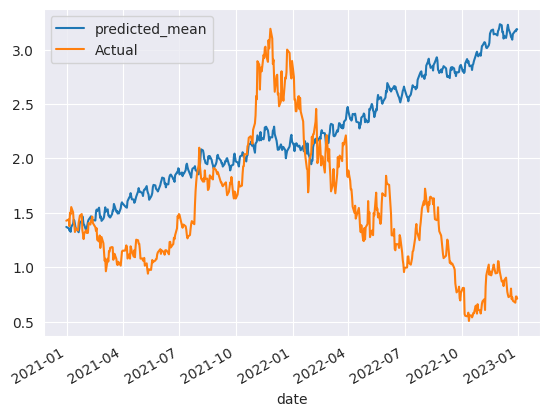

In [52]:
#Plotting the forecasted values

forecast_amd_with_tema_2 = pd.DataFrame(forecast)
forecast_amd_with_tema_2.reset_index(drop=True, inplace=True)
forecast_amd_with_tema_2.index = test_Y.index
forecast_amd_with_tema_2["Actual"] = test_Y
forecast_amd_with_tema_2.rename(columns={0: "predicted_close"}, inplace=True)
forecast_amd_with_tema_2["predicted_mean"].plot(legend=True)
forecast_amd_with_tema_2["Actual"].plot(legend=True)

In [53]:
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_absolute_percentage_error

error=calculate_rmse(forecast_amd_with_tema_2["predicted_mean"], forecast_amd_with_tema_2["Actual"])
print("The root mean squared error is {}.".format(error))

##calculate the mean absolute percentage error

mape = calculate_mape(forecast_amd_with_tema_2["Actual"],
                                      forecast_amd_with_tema_2["predicted_mean"])
print("The mean absolute percentage error is {}.".format(mape))

The root mean squared error is 1.102648578297295.
The mean absolute percentage error is 80.97807673871033.


In [54]:
#Predicting the values in the validation data using the SARIMAX model
df_for_validation_with_tema_2 = df_for_validation.drop(['tema_8', 'tema_100'], axis=1)
forecast = model_fit.forecast(steps=len(df_for_validation_with_tema_2), exog=df_for_validation_with_tema_2)

In [55]:
#Plotting the forecasted values

forecast_amd_with_tema_2= pd.DataFrame(forecast)
forecast_amd_with_tema_2.reset_index(drop=True, inplace=True)
forecast_amd_with_tema_2.index=df_for_validation_actual.index
forecast_amd_with_tema_2["Actual"] =df_for_validation_actual
forecast_amd_with_tema_2.rename(columns={0:"predicted_close"}, inplace=True)

<Axes: xlabel='date'>

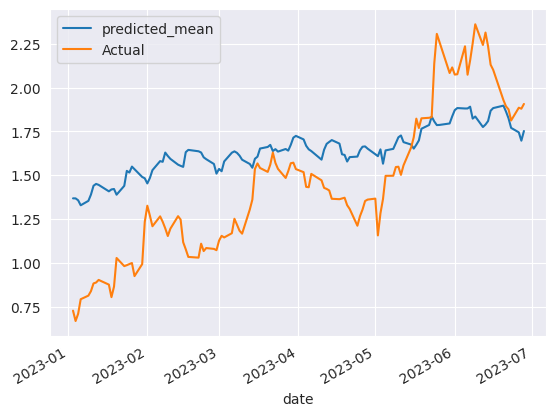

In [58]:
forecast_amd_with_tema_2["predicted_mean"].plot(legend=True)
forecast_amd_with_tema_2["Actual"].plot(legend=True)

In [59]:
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_absolute_percentage_error

error=calculate_rmse(forecast_amd_with_tema_2["predicted_mean"], forecast_amd_with_tema_2["Actual"])
print("The root mean squared error is {}.".format(error))

##calculate the mean absolute percentage error

mape = calculate_mape(forecast_amd_with_tema_2["Actual"],
                                      forecast_amd_with_tema_2["predicted_mean"])
print("The mean absolute percentage error is {}.".format(mape))

The root mean squared error is 0.3593258452202713.
The mean absolute percentage error is 26.403576511461935.


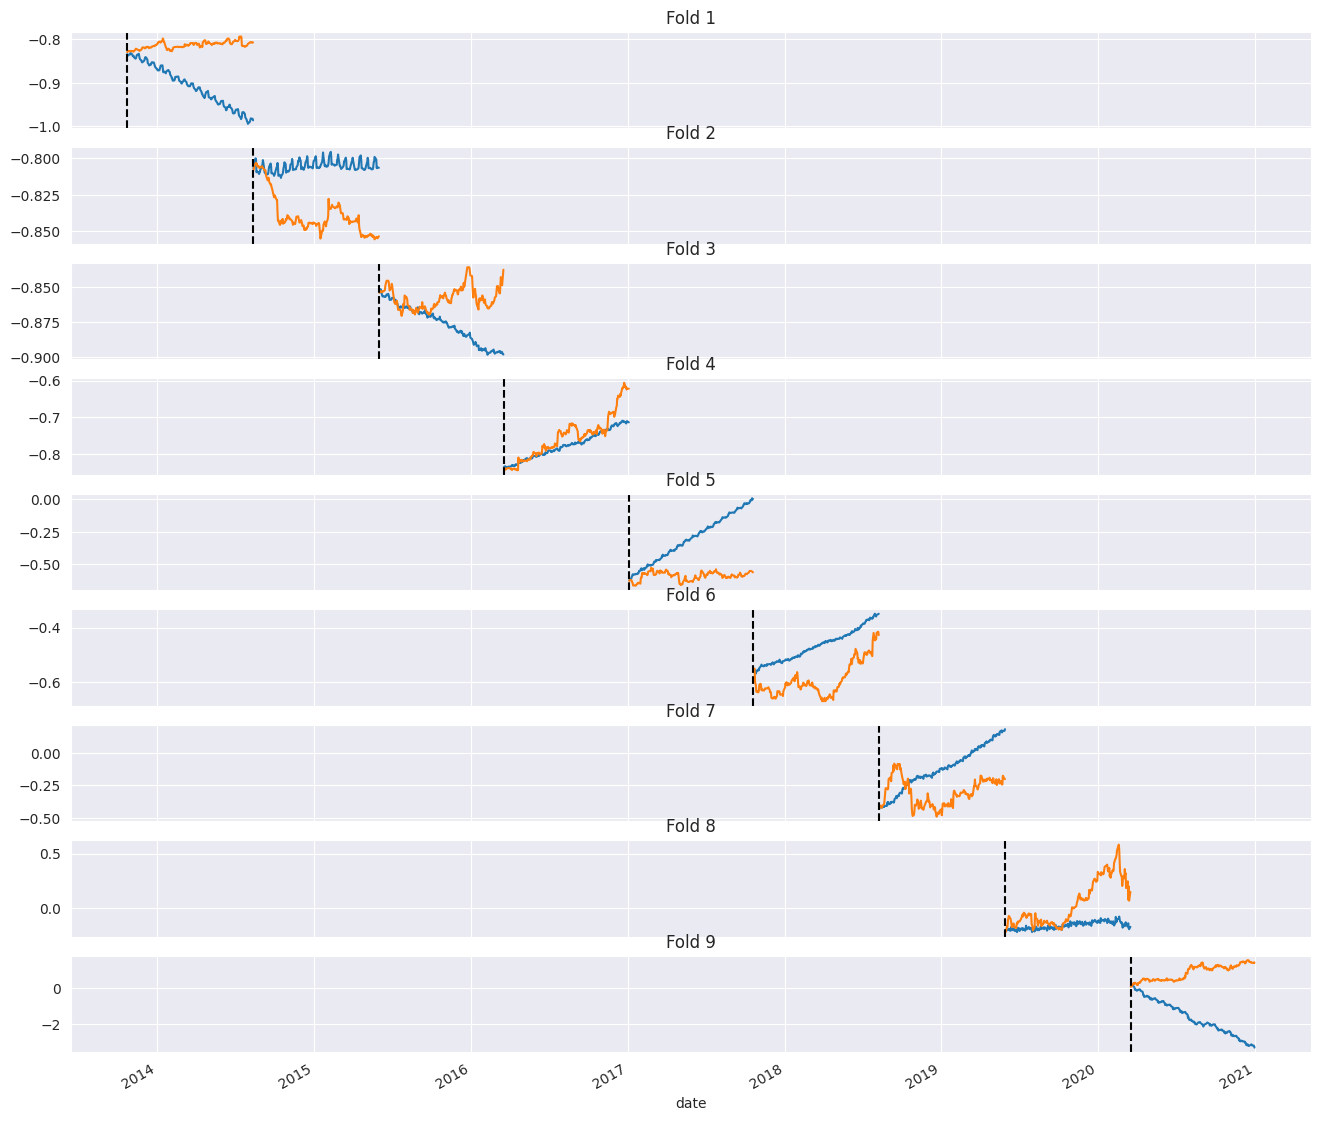

Average Mean Absolute Percentage Error:  1.3666437151201367


In [76]:
#Time series cross validation using TimeSeriesSplit from sklearn.model_selection library and mean_absolute_percentage_error from sklearn.metrics library. We use the SARIMAX model to fit the data and predict the values for the test data. We then calculate the mean
#absolute percentage error for the predicted values and the actual values. We then plot the predicted values and the actual values. We also plot the residuals of the model.

##using tema_8

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

total_samples = len(train_X_with_tema_8)  # Mỗi mẫu tương ứng với một năm

test_size_ratio = 0.1  # Tỷ lệ phần trăm dùng cho tập kiểm tra
test_size = int(total_samples * test_size_ratio)
tscv = TimeSeriesSplit(n_splits=9, test_size=test_size, gap=0)

train_X_with_tema_8 = train_X_with_tema_8.sort_index()
train_Y = train_Y.sort_index()
# print(train_X.head())
figure, ax = plt.subplots(9, 1 , figsize=(16, 15), sharex=True)
fold = 0
the_average_mape = 0

for train_index, test_index in tscv.split(train_X_with_tema_8):
    X_train, X_test = train_X_with_tema_8.iloc[train_index], train_X_with_tema_8.iloc[test_index]
    y_train, y_test = train_Y.iloc[train_index], train_Y.iloc[test_index]

    #turn off the output of the model
    model = SARIMAX(endog=y_train, exog=X_train, order=order, seasonal_order=seasonal_order)

    model_fit = model.fit(maxiter=200, method='powell', disp=False, full_output=False)
    y_pred = model_fit.forecast(steps=len(X_test), exog=X_test)

    y_pred.reset_index(drop=True, inplace=True)
    result = pd.DataFrame(y_pred)
    result.reset_index(drop=True, inplace=True)
    result.index=X_test.index
    result["Next date"] = y_test
    ##plot the predicted and actual values from y_pred and x_test
    result["predicted_mean"].plot(ax=ax[fold], label='Predicted Set', title='Fold {}'.format(fold+1))
    result["Next date"].plot(ax=ax[fold], label='Actual Set')
    ax[fold].axvline(X_test.index.min(), color='black', ls='--')
    fold+= 1

    mape = mean_absolute_percentage_error(y_test, y_pred)
    the_average_mape = the_average_mape + mape

plt.show()
print("Average Mean Absolute Percentage Error: ", the_average_mape/5)

In [60]:
#Predicting the values in the validation data using the SARIMAX model
model = SARIMAX(endog=train_Y, exog=train_X_with_tema_8, order=order, seasonal_order=seasonal_order,
                enforce_invertibility=False, enforce_stationarity=False)
model_fit = model.fit(maxiter=200, method='powell', disp=False, full_output=True)
print(model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                          Next date   No. Observations:                 2013
Model:             SARIMAX(2, 1, 0)x(2, 1, 0, 18)   Log Likelihood                4266.543
Date:                            Sat, 22 Jul 2023   AIC                          -8473.086
Time:                                    01:11:04   BIC                          -8305.726
Sample:                                         0   HQIC                         -8411.566
                                           - 2013                                         
Covariance Type:                              opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
open              0.3368      0.035      9.744      0.000       0.269       0.405
high             -0.1852  

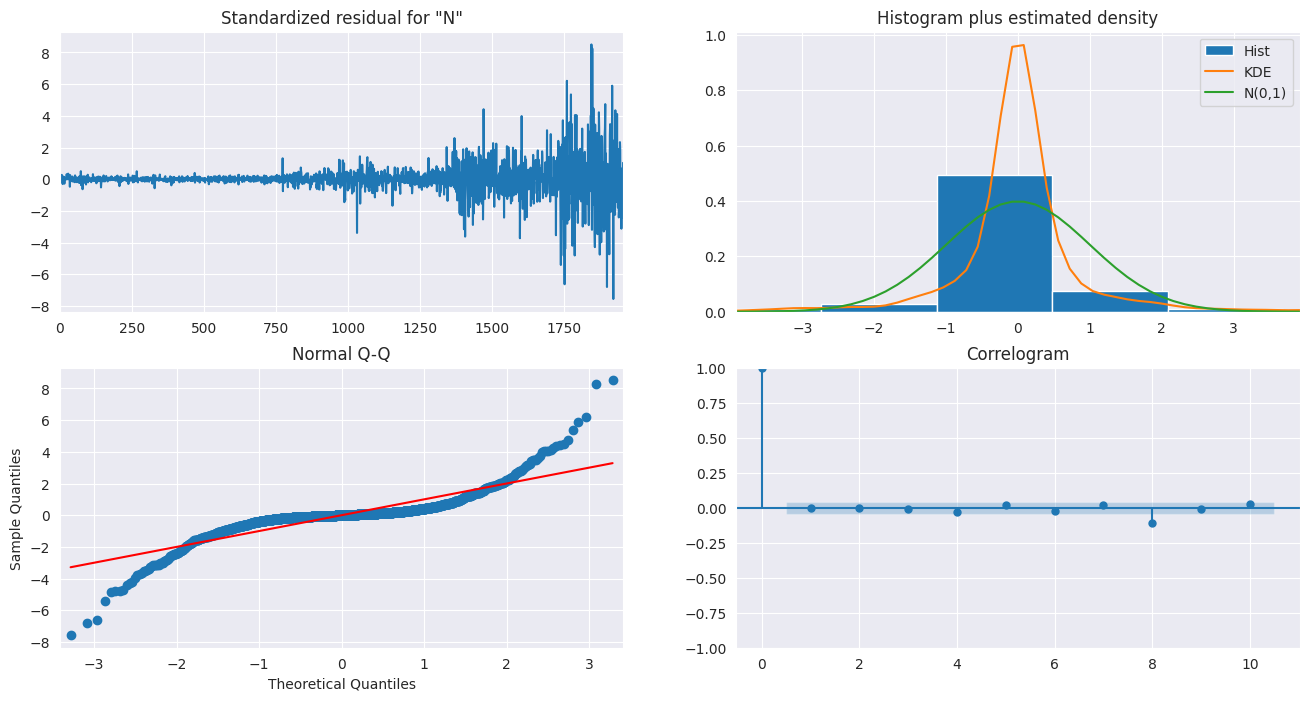

In [61]:
#Plot the result of model_fit

model_fit.plot_diagnostics(figsize=(16, 8))
plt.show()

In [62]:
#Predicting the values in the validation data using the SARIMAX model
df_for_validation_with_tema_8 = df_for_validation.drop(['tema_2', 'tema_100'], axis=1)
forecast = model_fit.forecast(steps=len(df_for_validation_with_tema_8), exog=df_for_validation_with_tema_8)

<Axes: xlabel='date'>

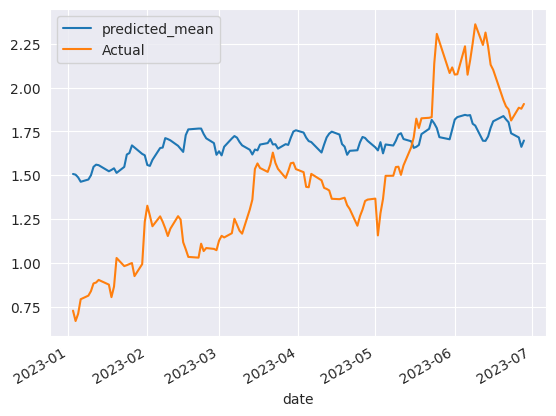

In [63]:
#Plotting the forecasted values

forecast_amd_with_tema_8 = pd.DataFrame(forecast)
forecast_amd_with_tema_8.reset_index(drop=True, inplace=True)
forecast_amd_with_tema_8.index = df_for_validation_actual.index
forecast_amd_with_tema_8["Actual"] = df_for_validation_actual
forecast_amd_with_tema_8.rename(columns={0: "predicted_close"}, inplace=True)
forecast_amd_with_tema_8["predicted_mean"].plot(legend=True)
forecast_amd_with_tema_8["Actual"].plot(legend=True)

In [64]:
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_absolute_percentage_error

error=calculate_rmse(forecast_amd_with_tema_2["predicted_mean"], forecast_amd_with_tema_2["Actual"])
print("The root mean squared error is {}.".format(error))

##calculate the mean absolute percentage error

mape = calculate_mape(forecast_amd_with_tema_2["Actual"],
                                      forecast_amd_with_tema_2["predicted_mean"])
print("The mean absolute percentage error is {}.".format(mape))

The root mean squared error is 0.3593258452202713.
The mean absolute percentage error is 26.403576511461935.


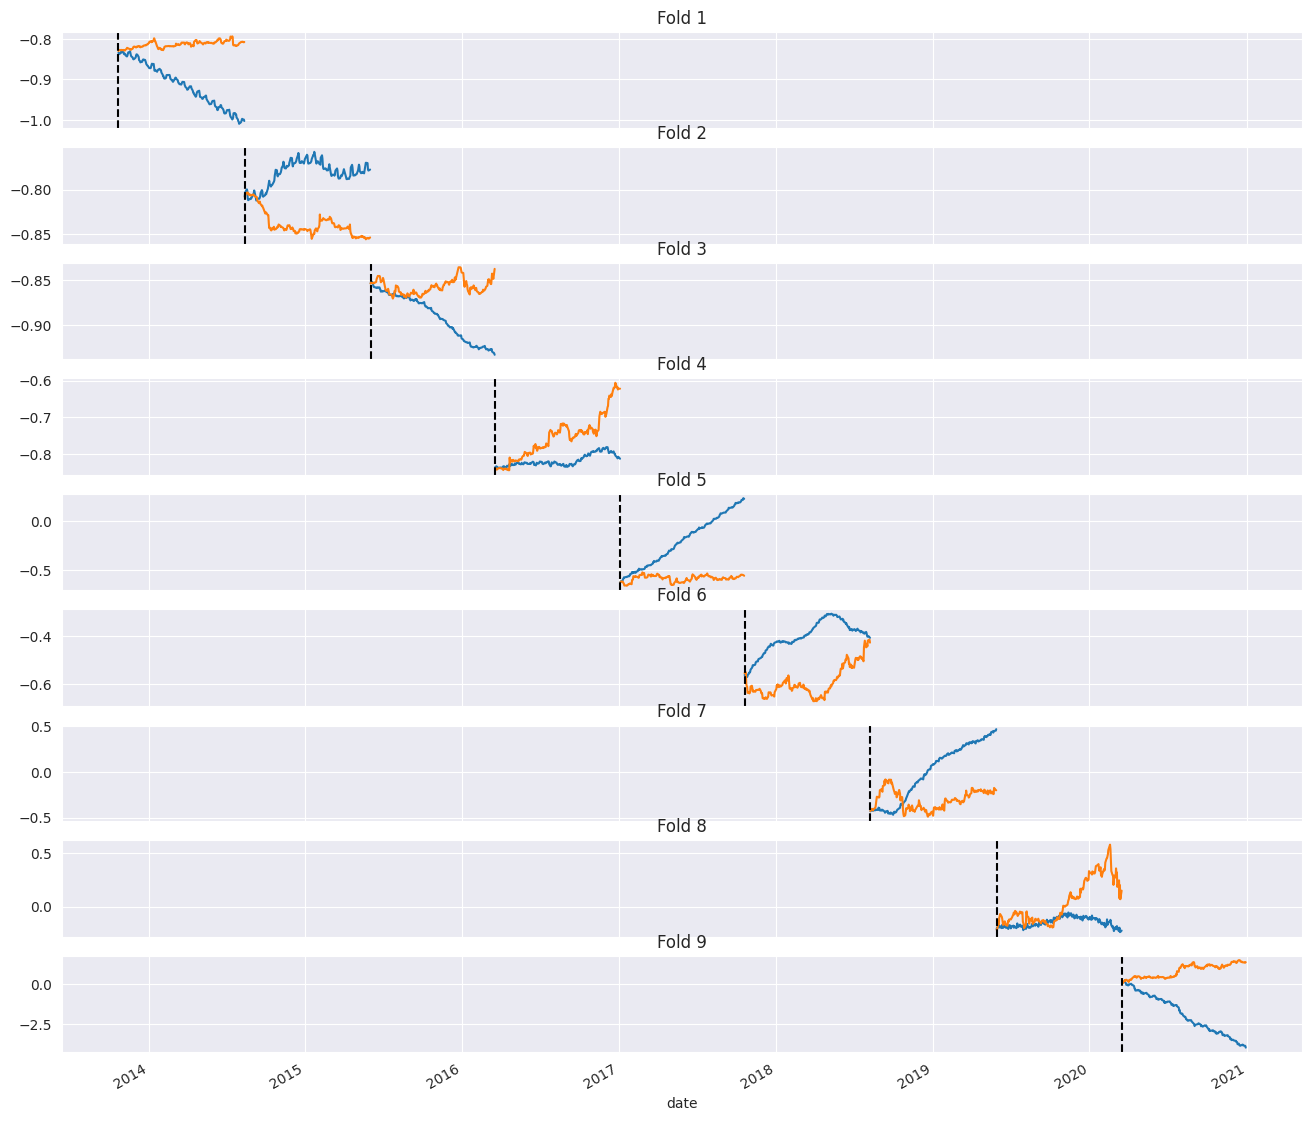

Average Mean Absolute Percentage Error:  1.4972327303190536


In [82]:
#Time series cross validation using TimeSeriesSplit from sklearn.model_selection library and mean_absolute_percentage_error from sklearn.metrics library. We use the SARIMAX model to fit the data and predict the values for the test data. We then calculate the mean
#absolute percentage error for the predicted values and the actual values. We then plot the predicted values and the actual values. We also plot the residuals of the model.

##using tema_100
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

total_samples = len(train_X_with_tema_100)  # Mỗi mẫu tương ứng với một năm

test_size_ratio = 0.1  # Tỷ lệ phần trăm dùng cho tập kiểm tra
test_size = int(total_samples * test_size_ratio)
tscv = TimeSeriesSplit(n_splits=9, test_size=test_size, gap=0)

train_X_with_tema_100 = train_X_with_tema_100.sort_index()
train_Y = train_Y.sort_index()
# print(train_X.head())
figure, ax = plt.subplots(9, 1 , figsize=(16, 15), sharex=True)
fold = 0
the_average_mape = 0


for train_index, test_index in tscv.split(train_X_with_tema_100):
    X_train, X_test = train_X_with_tema_100.iloc[train_index], train_X_with_tema_100.iloc[test_index]
    y_train, y_test = train_Y.iloc[train_index], train_Y.iloc[test_index]

    #turn off the output of the model
    model = SARIMAX(endog=y_train, exog=X_train, order=order, seasonal_order=seasonal_order)

    model_fit = model.fit(maxiter=200, method='powell', disp=False, full_output=False)
    y_pred = model_fit.forecast(steps=len(X_test), exog=X_test)

    y_pred.reset_index(drop=True, inplace=True)
    result = pd.DataFrame(y_pred)
    result.reset_index(drop=True, inplace=True)
    result.index=X_test.index
    result["Next date"] = y_test
    ##plot the predicted and actual values from y_pred and x_test
    result["predicted_mean"].plot(ax=ax[fold], label='Predicted Set', title='Fold {}'.format(fold+1))
    result["Next date"].plot(ax=ax[fold], label='Actual Set')
    ax[fold].axvline(X_test.index.min(), color='black', ls='--')
    fold+= 1

    mape = mean_absolute_percentage_error(y_test, y_pred)
    the_average_mape = the_average_mape + mape

plt.show()
print("Average Mean Absolute Percentage Error: ", the_average_mape/5)

In [65]:
#Predicting the values in the validation data using the SARIMAX model
model = SARIMAX(endog=train_Y, exog=train_X_with_tema_100, order=order, seasonal_order=seasonal_order,
                enforce_invertibility=False, enforce_stationarity=False)
model_fit = model.fit(maxiter=200, method='powell', disp=False, full_output=True)
print(model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                          Next date   No. Observations:                 2013
Model:             SARIMAX(2, 1, 0)x(2, 1, 0, 18)   Log Likelihood                4266.886
Date:                            Sat, 22 Jul 2023   AIC                          -8473.772
Time:                                    01:15:46   BIC                          -8306.413
Sample:                                         0   HQIC                         -8412.252
                                           - 2013                                         
Covariance Type:                              opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
open              0.3014      0.034      8.881      0.000       0.235       0.368
high             -0.2200  

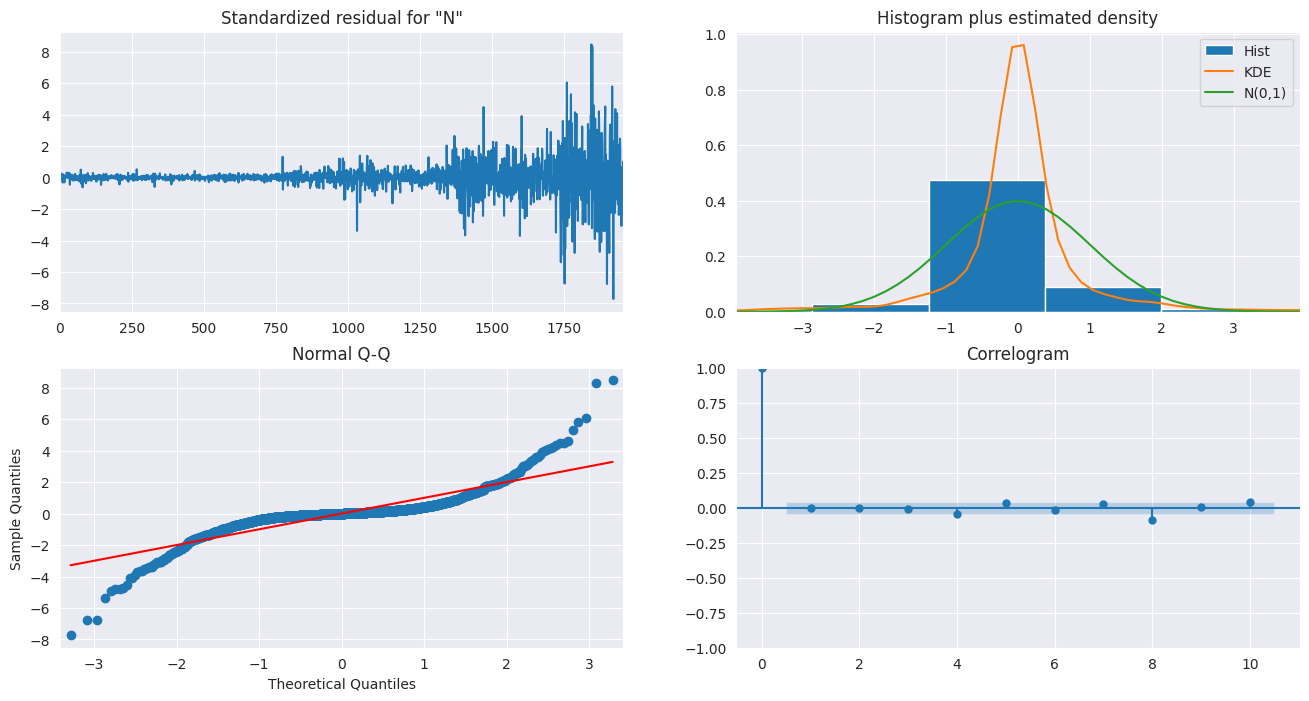

In [66]:
#Plot the result of model_fit

model_fit.plot_diagnostics(figsize=(16, 8))
plt.show()

In [67]:
#Predicting the values in the validation data using the SARIMAX model
df_for_validation_with_tema_100 = df_for_validation.drop(['tema_2', 'tema_8'], axis=1)
forecast = model_fit.forecast(steps=len(df_for_validation_with_tema_100), exog=df_for_validation_with_tema_100)

<Axes: xlabel='date'>

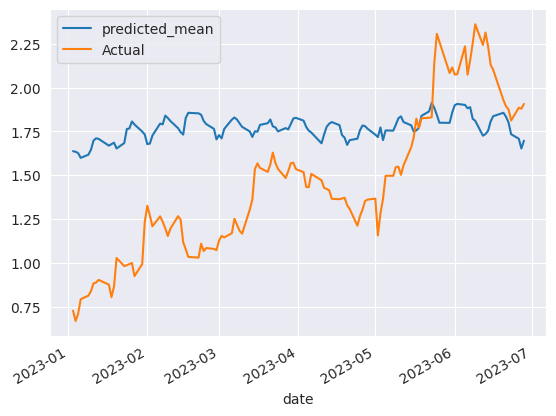

In [68]:
#Plotting the forecasted values

forecast_amd_with_tema_100 = pd.DataFrame(forecast)
forecast_amd_with_tema_100.reset_index(drop=True, inplace=True)
forecast_amd_with_tema_100.index = df_for_validation_actual.index
forecast_amd_with_tema_100["Actual"] = df_for_validation_actual
forecast_amd_with_tema_100.rename(columns={0: "predicted_close"}, inplace=True)
forecast_amd_with_tema_100["predicted_mean"].plot(legend=True)
forecast_amd_with_tema_100["Actual"].plot(legend=True)

In [69]:
#Calculate the root mean squared error
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_absolute_percentage_error

error = calculate_rmse(forecast_amd_with_tema_100["predicted_mean"], forecast_amd_with_tema_100["Actual"])
print("The root mean squared error is {}.".format(error))

##calculate the mean absolute percentage error

mape = calculate_mape(forecast_amd_with_tema_100["Actual"],
                      forecast_amd_with_tema_100["predicted_mean"])
print("The mean absolute percentage error is {}.".format(mape))

The root mean squared error is 0.5051880471063734.
The mean absolute percentage error is 38.15619967834619.


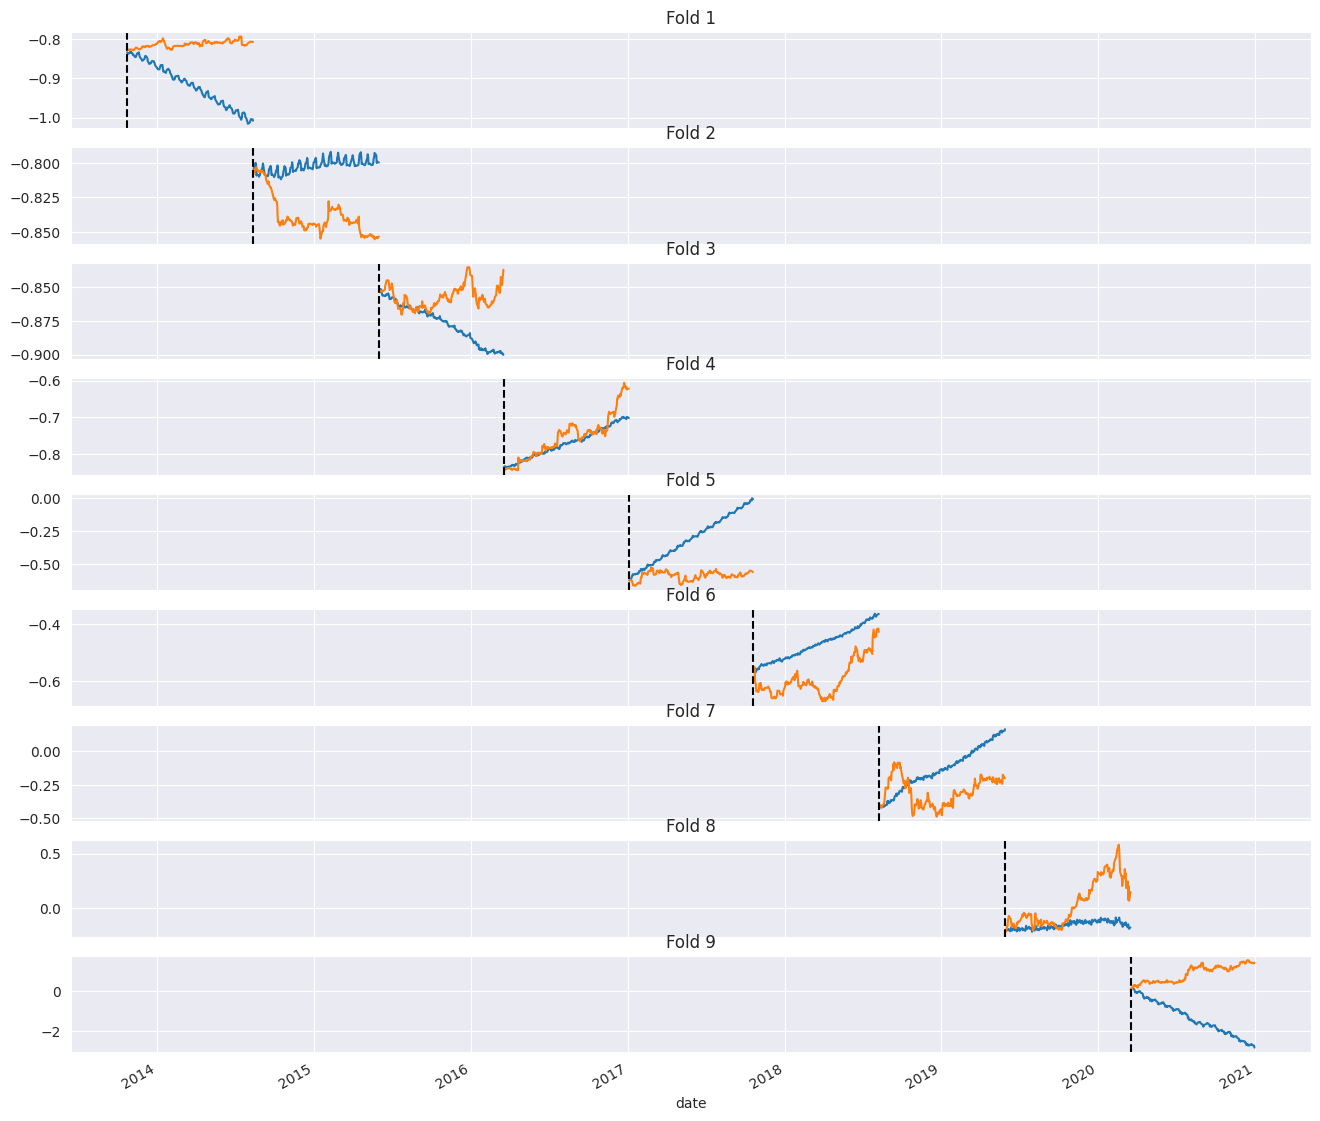

Average Mean Absolute Percentage Error:  1.274966240299816


In [87]:
#Time series cross validation using TimeSeriesSplit from sklearn.model_selection library and mean_absolute_percentage_error from sklearn.metrics library. We use the SARIMAX model to fit the data and predict the values for the test data. We then calculate the mean
#absolute percentage error for the predicted values and the actual values. We then plot the predicted values and the actual values. We also plot the residuals of the model.

##without tema

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

total_samples = len(train_X_without_tema)  # Mỗi mẫu tương ứng với một năm

test_size_ratio = 0.1  # Tỷ lệ phần trăm dùng cho tập kiểm tra
test_size = int(total_samples * test_size_ratio)
tscv = TimeSeriesSplit(n_splits=9, test_size=test_size, gap=0)

train_X_without_tema = train_X_without_tema.sort_index()
train_Y = train_Y.sort_index()
# print(train_X.head())
figure, ax = plt.subplots(9, 1 , figsize=(16, 15), sharex=True)
fold = 0
the_average_mape = 0

for train_index, test_index in tscv.split(train_X_without_tema):
    X_train, X_test = train_X_without_tema.iloc[train_index], train_X_without_tema.iloc[test_index]
    y_train, y_test = train_Y.iloc[train_index], train_Y.iloc[test_index]

    #turn off the output of the model
    model = SARIMAX(endog=y_train, exog=X_train, order=order, seasonal_order=seasonal_order)

    model_fit = model.fit(maxiter=200, method='powell', disp=False, full_output=False)
    y_pred = model_fit.forecast(steps=len(X_test), exog=X_test)

    y_pred.reset_index(drop=True, inplace=True)
    result = pd.DataFrame(y_pred)
    result.reset_index(drop=True, inplace=True)
    result.index=X_test.index
    result["Next date"] = y_test
    ##plot the predicted and actual values from y_pred and x_test
    result["predicted_mean"].plot(ax=ax[fold], label='Predicted Set', title='Fold {}'.format(fold+1))
    result["Next date"].plot(ax=ax[fold], label='Actual Set')
    ax[fold].axvline(X_test.index.min(), color='black', ls='--')
    fold+= 1

    mape = mean_absolute_percentage_error(y_test, y_pred)
    the_average_mape = the_average_mape + mape

plt.show()
print("Average Mean Absolute Percentage Error: ", the_average_mape/5)

In [70]:
#Predicting the values in the validation data using the SARIMAX model
model = SARIMAX(endog=train_Y, exog=train_X_without_tema, order=order, seasonal_order=seasonal_order,
                enforce_invertibility=False, enforce_stationarity=False)
model_fit = model.fit(maxiter=200, method='powell', disp=False, full_output=True)
print(model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                          Next date   No. Observations:                 2013
Model:             SARIMAX(2, 1, 0)x(2, 1, 0, 18)   Log Likelihood                4265.515
Date:                            Sat, 22 Jul 2023   AIC                          -8473.031
Time:                                    01:20:22   BIC                          -8311.250
Sample:                                         0   HQIC                         -8413.562
                                           - 2013                                         
Covariance Type:                              opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
open              0.3261      0.034      9.453      0.000       0.258       0.394
high             -0.1954  

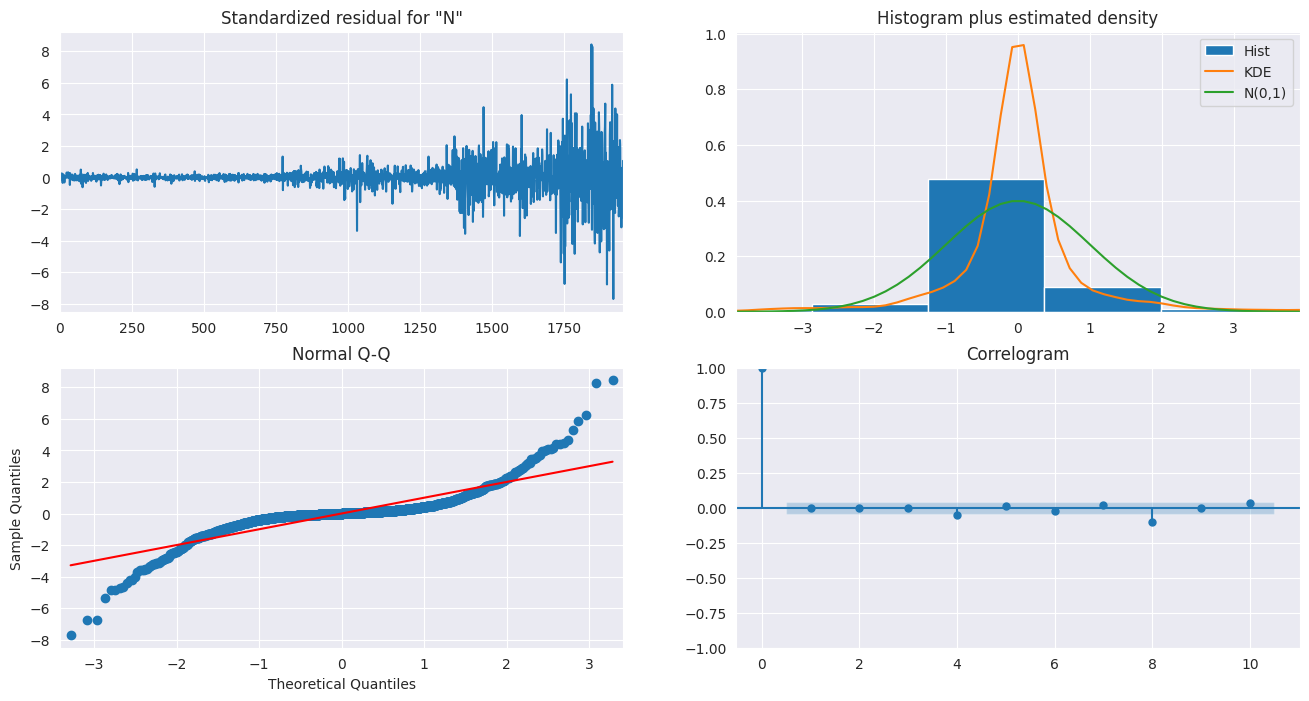

In [71]:
#Plot the result of model_fit

model_fit.plot_diagnostics(figsize=(16, 8))
plt.show()

In [72]:
#Predicting the values in the validation data using the SARIMAX model
df_for_validation_without_tema = df_for_validation.drop(['tema_2', 'tema_8', 'tema_100'], axis=1)
forecast = model_fit.forecast(steps=len(df_for_validation_without_tema), exog=df_for_validation_without_tema)

<Axes: xlabel='date'>

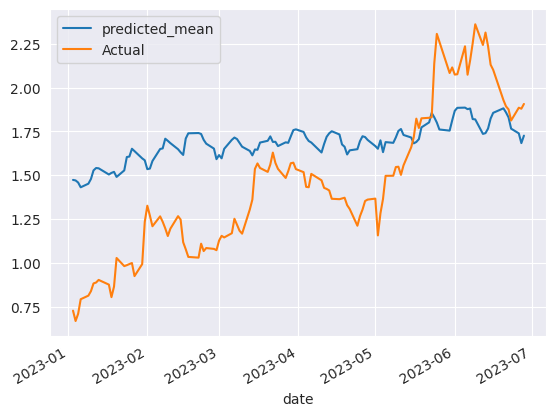

In [73]:
#Plotting the forecasted values

forecast_without_tema = pd.DataFrame(forecast)
forecast_without_tema.reset_index(drop=True, inplace=True)
forecast_without_tema.index = df_for_validation_actual.index
forecast_without_tema["Actual"] = df_for_validation_actual
forecast_without_tema.rename(columns={0: "predicted_close"}, inplace=True)
forecast_without_tema["predicted_mean"].plot(legend=True)
forecast_without_tema["Actual"].plot(legend=True)

In [74]:
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_absolute_percentage_error

error=calculate_rmse(forecast_without_tema["predicted_mean"], forecast_without_tema["Actual"])
print("The root mean squared error is {}.".format(error))

##calculate the mean absolute percentage error

mape = calculate_mape(forecast_without_tema["Actual"],
                                      forecast_without_tema["predicted_mean"])
print("The mean absolute percentage error is {}.".format(mape))

The root mean squared error is 0.41722429787214843.
The mean absolute percentage error is 31.048474635391155.
